# KITTI Data Wrangling and Exploration

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.model_selection import train_test_split

### The KITTI Dataset is split into two folders - one containing the raw images and one containing the labels
Here, we load both of those folders and create a DataFrame where each row corresponds to a single image and its labels. Column 1 (images) contains the path to the image. Column 2 (labels) contains the path to the labels.

In [3]:
# Load files into dataframe object
train_img_dir = 'data_object_image_2/training/image_2/'
train_label_dir = 'data_object_image_2/training/label_2/'

images =  [(train_img_dir + f) for f in listdir(train_img_dir) if isfile(join(train_img_dir, f))]
images.sort()
labels = [(train_label_dir + f) for f in listdir(train_label_dir) if isfile(join(train_label_dir, f))]
labels.sort()

df = pd.DataFrame(np.column_stack([images, labels]), columns=['images', 'labels'])

In [4]:
df.head()

,images,labels
0,data_object_image_2/training/image_2/000000.png,data_object_image_2/training/label_2/000000.txt
1,data_object_image_2/training/image_2/000001.png,data_object_image_2/training/label_2/000001.txt
2,data_object_image_2/training/image_2/000002.png,data_object_image_2/training/label_2/000002.txt
3,data_object_image_2/training/image_2/000003.png,data_object_image_2/training/label_2/000003.txt
4,data_object_image_2/training/image_2/000004.png,data_object_image_2/training/label_2/000004.txt


## Exploring the Data

The KITTI Dataset contains correct labels and no missing data, so wrangling is not required. We can split the images into Training and Validation immediately

In [5]:
df_train, df_val = train_test_split(df, test_size=0.5)

In [6]:
# Get the shape of a single Image
dsg = cv2.imread(df.loc[0][0])
print(dsg.shape)

(370, 1224, 3)


### KITTI Labels

In order to make a mask, we first must understand how to interpret the labels text files. The text file contains one line corresponding to each labeled object in the respective image. An example line is the following:

> Pedestrian 0.00 0 -0.20 712.40 143.00 810.73 307.92 1.89 0.48 1.20 1.84 1.47 8.41 0.01

The first word, Pedestrian, is the label of the object. Other labels include Car, Van, Truck, and DontCare. The other relevant fields for our purposes are the 5th-8th entries - 712.40 143.00 810.73 307.92 in the above example. These numbers refer to the pixel boundaries of the object. In the image above, the pedestrian takes up pixels 712.40 to 810.73 on the x-axis, and pixels 143.00 to 307.92 on the y-axis.

### Image Masks

A mask here is defined as the parts (pixels) of the image that correspond to an object listed in that image's labels. This method creates a mask for an image given the labels for that image as well as the shape of the image. create_mask() returns a 2 dimensional binary array where 0 corresponds to non-objects and 1 corresponds to classified objects. It also returns a list of bounding boxes in the image, which will be explained later.

In [7]:
# Create mask for defined image (shows a map of what pixels contain a vehicle)
def create_mask(mask_directory, img_shape):
    bound_boxes = []
    mask = np.zeros(shape=(img_shape[0], img_shape[1], 1))
    with open(mask_directory) as f:
        content = f.readlines()
    contents = [x.split() for x in content]
    for content in contents:
        obj = content[0]
        if (obj in ['Car', 'Truck', 'Van']): # Get pixels containing a vehicle
            start_col = int(float(content[4]))
            start_row = int(float(content[5]))
            end_col = int(float(content[6]))
            end_row = int(float(content[7]))
            mask[start_row:end_row, start_col:end_col, 0] = 1
            bound_boxes.append((start_row, end_row, start_col, end_col))
        # TODO: Also mark pedestrians/cyclist/person_sitting
#        elif (obj in ['Pedestrian', 'Cyclist', 'Person_sitting']):
#            start_col = int(float(content[4]))
#            start_row = int(float(content[5]))
#            end_col = int(float(content[6]))
#            end_row = int(float(content[7]))
#            mask[start_row:end_row, start_col:end_col, 0] = 2
    return mask, bound_boxes

Here, we test the create_mask() function. We print an image as well as its mask

images    data_object_image_2/training/image_2/002551.png
labels    data_object_image_2/training/label_2/002551.txt
Name: 2551, dtype: object
[(179, 214, 622, 718), (180, 206, 655, 688)]


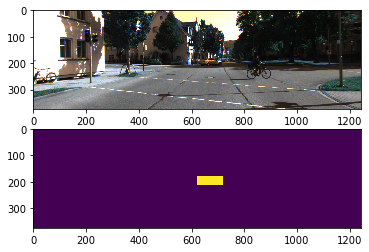

In [27]:
# Explore Masks
print(df_train.iloc[4])
test_image = df_train.iloc[4].images
test_label = df_train.iloc[4].labels
image_st = cv2.imread(test_image)
mtest, bb = create_mask(test_label, image_st.shape)
print(bb)
f, axarr = plt.subplots(2,1)
axarr[0].imshow(image_st)
axarr[1].imshow(mtest[:,:,0])

As shown above, the car in the background (which is a bit hard to see) of the first image is represented by the yellow box in the second image.

### Bounding Boxes

Bounding boxes are a fundamental part of image detection. A bounding box defines the boundaries for a desired object in an image. If there are multiple objects detected in an image, there will be multiple bounding boxes.

We will now create masks for every image in the training dataset. create_images_generator() will call create_mask() on each row of the DataFrame, getting both the mask and bounding boxes for every image. Since we are resizing the images for display purposes, we will need to resize the mask and bounding boxes accordingly. The function will return three objects (the resized image, the resized mask, and the resized bounding boxes) for each image in the training set.

In [32]:
def create_images_generator(df_in, batch_size, resized_shape):
    batch_image = []
    batch_mask = []
    batch_bounds = []
    df_in_list = (df_in).values.tolist()
    np.random.shuffle(df_in_list)
    
    while True:
        for image_path, mask_path in df_in_list:
            image = cv2.imread(image_path)
            # Get mask and bounding boxes for given image
            mask, bound_boxes = create_mask(mask_path, image.shape)
            
            # Resize image and mask
            image_r = cv2.resize(image,(resized_shape[1], resized_shape[0]))
            mask_r = cv2.resize(mask,(resized_shape[1], resized_shape[0]))
            bound_box_r = []
            # Resize bounding boxes
            scale_x = resized_shape[1]/image.shape[1]
            scale_y = resized_shape[0]/image.shape[0]
            print("Before:", bound_boxes) # Boxes before resizing
            for box in bound_boxes:
                bound_box_r.append((int(box[0]*scale_y), int(box[1]*scale_y), 
                                    int(box[2]*scale_x), int(box[3]*scale_x)))
            print("After:", bound_box_r) # Boxes after resizing
            
            batch_image.append(image_r)
            batch_mask.append(mask_r)
            batch_bounds.append(bound_box_r)
            
            if len(batch_mask) >= batch_size:
                yield np.float32(np.stack((batch_image), 0)/255.0), np.stack(np.uint8(np.expand_dims(batch_mask, -1)), 0), batch_bounds
                batch_image, batch_mask, batch_bounds = [], [], []

In [33]:
train_gen = create_images_generator(df_train, batch_size=64, resized_shape=(160, 256))
batch_img, batch_mask, batch_bx = next(train_gen)

Before: [(177, 204, 465, 543), (174, 208, 657, 697), (180, 211, 547, 586), (177, 223, 364, 498), (176, 239, 308, 473), (177, 256, 236, 458), (173, 266, 130, 359), (156, 300, 14, 366), (187, 245, 693, 780), (196, 337, 739, 974)]
After: [(75, 87, 95, 111), (74, 88, 135, 143), (76, 90, 112, 120), (75, 95, 75, 102), (75, 101, 63, 97), (75, 109, 48, 94), (73, 113, 26, 73), (66, 128, 2, 75), (79, 104, 142, 160), (83, 143, 152, 200)]
Before: [(163, 226, 618, 714), (167, 199, 538, 590), (165, 269, 868, 1138), (167, 270, 1153, 1241), (162, 186, 489, 546), (161, 187, 582, 642), (160, 180, 679, 720)]
After: [(69, 96, 127, 147), (71, 84, 110, 121), (70, 114, 178, 234), (71, 115, 237, 255), (69, 79, 100, 112), (68, 79, 119, 132), (68, 76, 139, 148)]
Before: [(181, 306, 348, 494), (183, 252, 446, 532)]
After: [(77, 130, 71, 101), (78, 107, 91, 109)]
Before: [(172, 195, 287, 331), (170, 192, 324, 362), (164, 208, 0, 46), (172, 190, 355, 383), (170, 225, 582, 637)]
After: [(73, 83, 59, 68), (72, 81, 6

Before: [(106, 374, 875, 1241), (207, 374, 0, 337), (197, 274, 351, 469), (179, 242, 424, 505), (151, 203, 527, 573), (177, 207, 603, 637)]
After: [(45, 159, 180, 255), (88, 159, 0, 69), (84, 116, 72, 96), (76, 103, 87, 104), (64, 86, 108, 118), (75, 88, 124, 131)]
Before: [(177, 208, 577, 611), (181, 308, 0, 208), (192, 312, 215, 425), (192, 244, 241, 355), (185, 237, 419, 497), (180, 221, 371, 432), (183, 217, 468, 519), (185, 210, 503, 538), (171, 226, 229, 329)]
After: [(75, 88, 119, 126), (77, 131, 0, 42), (81, 132, 44, 87), (81, 103, 49, 73), (78, 100, 86, 102), (76, 94, 76, 89), (77, 92, 96, 107), (78, 89, 103, 110), (72, 96, 47, 67)]
Before: [(177, 237, 436, 519), (178, 206, 531, 562), (177, 194, 558, 578), (174, 217, 589, 633)]
After: [(75, 101, 89, 106), (75, 87, 109, 115), (75, 82, 115, 119), (74, 92, 121, 130)]
Before: [(193, 337, 140, 406), (182, 228, 445, 507), (152, 211, 479, 536), (177, 214, 543, 586), (177, 199, 525, 552)]
After: [(82, 143, 28, 83), (77, 97, 91, 104), 

## Display Results of Exploration

get_bounding_box() takes in an image and its bounding box coordinates, and will draw the bounding boxes on a copy of the image

In [62]:
def get_bounding_box(img, bound_boxes_coord):
    im_boxed = im.copy()
    for box in bound_boxes_coord:
        color = np.random.randint(0, 255, size=(3, ))
        color = (int(color[0]), int(color[1]), int(color[2])) 
        cv2.rectangle(im_boxed, (box[2], box[0]), (box[3], box[1]), tuple(color), 2)
    return im_boxed

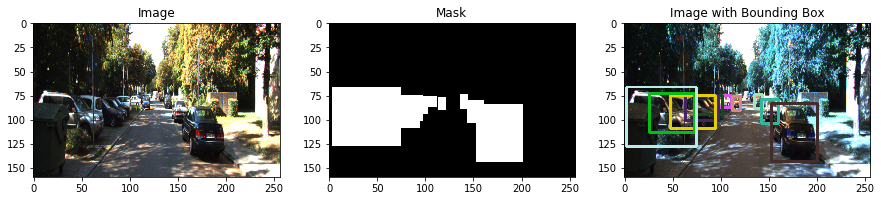

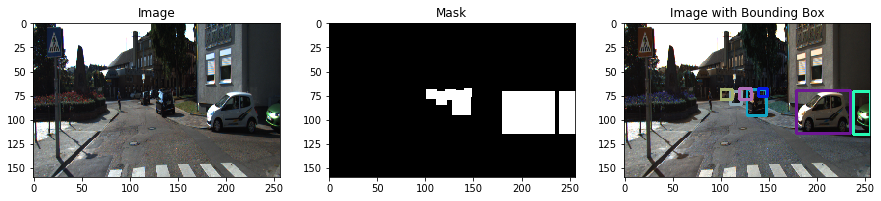

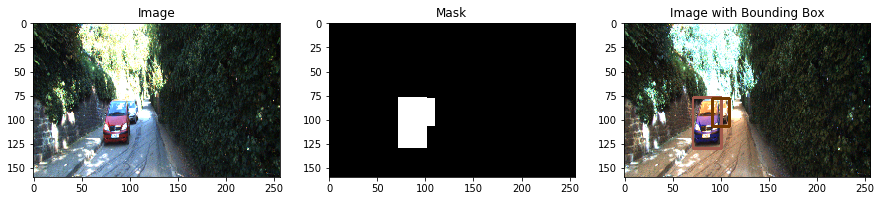

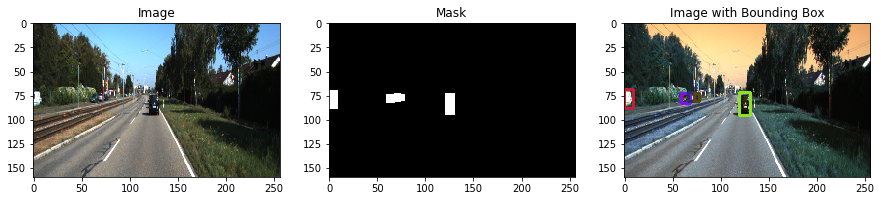

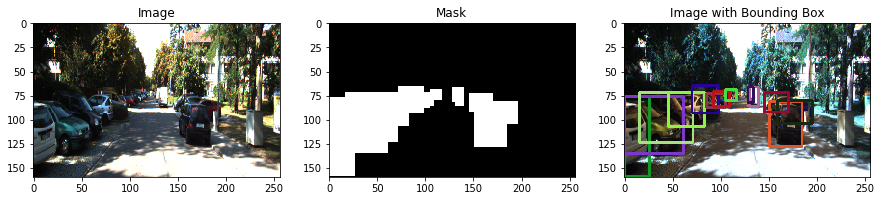

In [63]:
# See mask results
for i in range(5):
    im = np.array(255*batch_img[i], dtype=np.uint8)
    im_mask = np.array(batch_mask[i], dtype=np.uint8)
    boxes = get_bounding_box(im, batch_bx[i])
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    ax1.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax1.set_title('Image')
    ax2.imshow(im_mask[:,:,0], cmap='gray')
    ax2.set_title('Mask')
    ax3.imshow(boxes)
    ax3.set_title('Image with Bounding Box')
    plt.show()

    #plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    #plt.figure()
    #plt.imshow(im_mask[:,:,0], cmap= 'gray')
    #plt.show()

Above, we printed the results of our functions on five of the images in the training set. The first image in the row is the original image. The second image is the mask of that image, where areas in white correspond to objects that are defined in the image's labels. The third image draws bounding boxes around each object defined in the labels.

This exercise shows how the KITTI labels define an object for any image. Now that we know how labels work, we will eventually be able to understand how to model images in the KITTI Dataset.